<a href="https://colab.research.google.com/github/Niraj1608/spam-classifier/blob/main/Copy_of_notebookf5e0be4d15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:


!pip install kaggle

from google.colab import files



# List available datasets.
!kaggle datasets list

# Download the dataset
!kaggle datasets download -d topkek69/captcha



Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
Dataset URL: https://www.kaggle.com/datasets/topkek69/captcha
License(s): unknown
 73% 17.0M/23.2M [00:00<00:00, 85.5MB/s]
100% 23.2M/23.2M [00:00<00:00, 97.0MB/s]


In [2]:


!unzip captcha -d extracted_data

Streaming output truncated to the last 5000 lines.
  inflating: extracted_data/train/cb2kbr8.png  
  inflating: extracted_data/train/cb3bb6p.png  
  inflating: extracted_data/train/cbgc79t.png  
  inflating: extracted_data/train/cbjk8t.png  
  inflating: extracted_data/train/cbp3be.png  
  inflating: extracted_data/train/cbth1jm.png  
  inflating: extracted_data/train/cbuc4f.png  
  inflating: extracted_data/train/ccdjdl.png  
  inflating: extracted_data/train/ccfcrz.png  
  inflating: extracted_data/train/ccp4d2b.png  
  inflating: extracted_data/train/ccpkyy4.png  
  inflating: extracted_data/train/ccu64y.png  
  inflating: extracted_data/train/ccz1gu.png  
  inflating: extracted_data/train/ccz59nt.png  
  inflating: extracted_data/train/cczpejf.png  
  inflating: extracted_data/train/cd1tkf.png  
  inflating: extracted_data/train/cd2mh4.png  
  inflating: extracted_data/train/cddgsml.png  
  inflating: extracted_data/train/cdga3y.png  
  inflating: extracted_data/train/cdgp2j5.png  

In [3]:
!pip install -q transformers

In [4]:
!pip install -q evaluate jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [5]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import random
import matplotlib.pyplot as plt
from evaluate import load
from transformers import AdamW
from tqdm.notebook import tqdm
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, VisionEncoderDecoderConfig
import warnings

warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = 'false'

In [6]:
# Define the paths
dataset_dir = '/content/extracted_data'
train_dir = os.path.join(dataset_dir, 'train')
valid_dir = os.path.join(dataset_dir, 'valid')
test_dir = os.path.join(dataset_dir, 'test')

In [7]:
class CaptchaDataset(Dataset):
    def __init__(self, root_dir, processor, max_target_length=10):
        self.root_dir = root_dir
        self.data = []
        self.processor = processor
        self.max_target_length = max_target_length

        for file_name in os.listdir(self.root_dir):
            self.data.append((os.path.join(root_dir, file_name), file_name.removesuffix('.png')))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get file name + text
        file_path, text = self.data[idx]

        # prepare image (i.e. resize + normalize)
        image = Image.open(file_path).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values

        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [8]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-handwritten")
train_dataset = CaptchaDataset(root_dir=train_dir, processor=processor)
valid_dataset = CaptchaDataset(root_dir=valid_dir, processor=processor)
test_dataset = CaptchaDataset(root_dir=test_dir, processor=processor)

preprocessor_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

In [9]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))
print("Number of testing examples:", len(test_dataset))

Number of training examples: 6839
Number of validation examples: 684
Number of testing examples: 683


In [10]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([10])


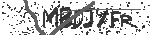

In [11]:
image = Image.open(os.path.join(train_dir, os.listdir(train_dir)[0])).convert("RGB")
image

In [12]:
os.listdir(train_dir)[0].removesuffix('.png')

'mbdjyfr'

In [13]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

mbdjyfr


In [14]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=16)

In [15]:
from transformers import VisionEncoderDecoderModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-handwritten")
model.to(device)

config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(

In [16]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 10
model.config.length_penalty = 0
model.config.early_stopping = True
model.config.num_beams = 2

In [17]:
cer_metric = load("cer")

def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

In [18]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

for epoch in range(5):  # loop over the dataset multiple times
   # train
   model.train()
   train_loss = 0.0
   for batch in tqdm(train_dataloader):
      # get the inputs
      for k,v in batch.items():
        batch[k] = v.to(device)

      # forward + backward + optimize
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()

   print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))

   # evaluate
   model.eval()
   valid_cer = 0.0
   with torch.no_grad():
     for batch in tqdm(valid_dataloader):
       # run batch generation
       outputs = model.generate(batch["pixel_values"].to(device))
       # compute metrics
       cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
       valid_cer += cer

   print("Validation CER:", valid_cer / len(valid_dataloader))

model.save_pretrained("OCR-model")


  0%|          | 0/428 [00:00<?, ?it/s]

Loss after epoch 0: 3.8448653165425095


  0%|          | 0/43 [00:00<?, ?it/s]

Validation CER: 1.0048801677797627


  0%|          | 0/428 [00:00<?, ?it/s]

Loss after epoch 1: 3.459976283746345


  0%|          | 0/43 [00:00<?, ?it/s]

Validation CER: 0.9432677588727909


  0%|          | 0/428 [00:00<?, ?it/s]

Loss after epoch 2: 2.1470828956671966


  0%|          | 0/43 [00:00<?, ?it/s]

Validation CER: 0.20064514818738174


  0%|          | 0/428 [00:00<?, ?it/s]

Loss after epoch 3: 0.5064248686186342


  0%|          | 0/43 [00:00<?, ?it/s]

Validation CER: 0.07672625015890845


  0%|          | 0/428 [00:00<?, ?it/s]

Loss after epoch 4: 0.30253799785381164


  0%|          | 0/43 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 10, 'early_stopping': True, 'num_beams': 2, 'length_penalty': 0}


Validation CER: 0.06760989377324614


In [19]:
# loading model and config from pretrained folder
encoder_decoder_config = VisionEncoderDecoderConfig.from_pretrained("OCR-model")
OCR_model = VisionEncoderDecoderModel.from_pretrained("OCR-model", config=encoder_decoder_config).to(device)

TEST

In [20]:
def random_infer():
    # Get a random image path from the test folder
    image_files = [f for f in os.listdir('/content/extracted_data/test') if f.endswith('.png')]
    random_image_file = random.choice(image_files)
    print(random_image_file)

    image_path = os.path.join('/content/extracted_data/test', random_image_file)
    image = Image.open(image_path)
    plt.imshow(image)

    # Process the image
    pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)
    #print(f"Pixel values shape: {pixel_values.shape}")

    # Generate text from the image
    generated_ids = OCR_model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    #print(f"Generated text: {generated_text}")

    return generated_text

47zb5br.png


'47zb5br'

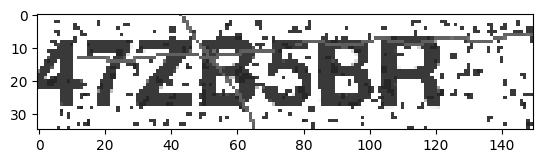

In [21]:
random_infer()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')